# Structural Topic Model (STM)

##### Author information
- **Name:** Jaeseong Choe

- **email address:** 21900759@handong.ac.kr

- **GitHub:** https://github.com/sorrychoe

- **Linkedin:** https://www.linkedin.com/in/jaeseong-choe-048639250/

- **Personal Webpage:** https://jaeseongchoe.vercel.app/

## Part 1. Brief background of methodology

### Overview

- **Structural Topic Model(STM) incorporates document-level metadata into the topic modeling process**. 

- It allows **the inclusion of external information (metadata) to influence the document's topic distribution**.


### Situation Before STM

- Topic models like LDA treat documents independently and ignore document-specific covariates.

### Why STM Was Introduced

- STM was introduced from the paper *"A model of text for experimentation in the social sciences."* of Roberts, M. E., Stewart, B. M., & Airoldi, E. M. (2016).

- STM allows for incorporating document-level metadata (e.g., author, date) to influence topic discovery.

### Use Cases

- STM is useful for analyzing how different factors (e.g., authorship, political affiliation) affect topic prevalence.

## Part 2. Key concept of methodology

### Key Concept

- STM incorporates metadata as a covariate affecting the topic distribution, allowing document-specific factors to influence topic discovery.

### Generative Process

1. **Covariate Effect on Topic Prevalence**:
   - For each document $d$, the topic distribution $\theta_d$ is influenced by covariates $X_d$. The topic proportions $\theta_d$ are drawn from a logistic normal distribution:
   $$
   \theta_d \sim \text{LogisticNormal}(\mu_d, \Sigma)
   $$
   where $\mu_d = X_d \gamma$, and $\Sigma$ is the covariance matrix.

2. **Topic Assignment**:
   - For each word $w_{dn}$ in document $d$, draw a topic assignment $z_{dn}$ from a multinomial distribution:
   $$
   z_{dn} \sim \text{Multinomial}(\theta_d)
   $$

3. **Covariate Effect on Topic Content**:
   - The word distribution $\beta_k$ for topic $k$ depends on the covariates $Y_d$. The distribution over words is modeled as a multinomial logistic regression:
   $$
   \beta_{d,k,v} \propto \exp(m_v + \kappa_k^{(t)} + \kappa_v^{(c)} + \kappa_{kv}^{(i)})
   $$
   where:
   - $m_v$ is the marginal log frequency of term $v$,
   - $\kappa_k^{(t)}$ is the topic-specific effect,
   - $\kappa_v^{(c)}$ is the covariate-specific effect,
   - $\kappa_{kv}^{(i)}$ is the topic-covariate interaction effect.

4. **Word Generation**:
   - For each word $w_{dn}$, draw a word from the multinomial distribution based on the assigned topic $z_{dn}$:
   $$
   w_{dn} \sim \text{Multinomial}(\beta_{z_{dn}})
   $$

![STM_Graphic](./img/STM_Graphic.png)

### Mathematical Representation

- **Topic Prevalence Model**:
   The topic proportions $\theta_d$ are modeled as a logistic normal distribution:
   $$
   \theta_d = \frac{\exp(\eta_d)}{\sum_k \exp(\eta_d,k)}
   $$
   where $\eta_d \sim \mathcal{N}(X_d \gamma, \Sigma)$.

- **Topic Content Model**:
   The word distribution for each topic $\beta_k$ is influenced by the covariates $Y_d$:
   $$
   \beta_{k,v} \propto \exp(m_v + \kappa_k^{(t)} + \kappa_v^{(c)} + \kappa_{kv}^{(i)})
   $$

### Inference

STM uses **variational expectation-maximization (EM)** for approximate inference due to the non-conjugacy of the logistic normal distribution with the multinomial likelihood.

- **Variational E-Step**:
   The variational posterior for $\eta_d$ is approximated using a Laplace approximation:
   $$
   q(\eta_d) \approx \mathcal{N}(\lambda_d, \nu_d)
   $$
   where $\lambda_d$ is the mode of $\eta_d$, and $\nu_d$ is the Hessian of the log-posterior.

- **Variational M-Step**:
   The M-step maximizes the ELBO with respect to the model parameters $\gamma, \kappa, \Sigma$. The updates for $\gamma$ are obtained through linear regression, while $\beta$ is updated using a multinomial logistic regression.

### Strength

- STM captures how external factors affect topic prevalence and topic content.

## Part 3. Example

### Before Sample code

- No library exists that implements stm exactly as the formula stated in the paper in Python. 

- However, there exists in R. Because of this reason, All codes are written in R.

- In this sample code, I use the `stm` package of R

### Precautions

- If you re-execute the code, there may be a slight difference in the result.

- Of course, the difference in the number or content of the topic will not be significant due to the seed number and the learning rate, but the number of the topic changes.

In [1]:
# import librarys
library(stm) # for stm 
library(tidyverse) # for Data preprocessing(dplyr, tidyr), visualization(ggplot2) & use pipeline operator(magrittr)
library(tidytext) # for Text preprocessing
library(tm) # for Text preprocessing
library(showtext) # for set the Korean font
library(readxl) # for load excel data

font_add_google(name = "Nanum Gothic", family = "nanumgothic") # korean font setup
showtext_auto()

# set the seed number
set.seed(42)

stm v1.3.7 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
필요한 패키지를 로딩중입니다: NLP


다음의 패키지를 부착합니다: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


필요한 패키지를 로딩중입니다: sysfonts

필요한 패키지를 로딩중입니다: showtextdb



In [2]:
# data load
# The data is related to Handong University, 
# which was reported in major Korean daily newspapers from January 1995 to September 2024.
df <- read_xlsx("data/NewsResult_19950101-20240930.xlsx")

# data preprocessing
df$키워드 <- gsub(",", " ", df$키워드)

df$Date <- as.Date(df$일자, format = "%Y%m%d")

df$Press <- as.factor(df$언론사)

# Process a vector of raw texts
processed <- textProcessor(documents = df$키워드, metadata = df)

# Prepare documents for analysis
out <- prepDocuments(processed$documents, processed$vocab, processed$meta)

# add meta data at documents
out$meta$Date <- df$Date
out$meta$Press <- df$Press

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 58361 of 98864 terms (58361 of 453771 tokens) due to frequency 
Your corpus now has 8051 documents, 40503 terms and 395410 tokens.

In [3]:
# find proper k value
topicN <- seq(3, 10)
topicN_storage <- searchK(out$documents, out$vocab, K = topicN) 
# searchK() is non-deterministic, It is outside the influence of the seed number.

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Using only 10000 most frequent terms during initialization...
	 Finding anchor words...
 	...
	 Recovering initialization...
 	....................................................................................................
Initialization complete.
....................................................................................................
Completed E-Step (1 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -9.560) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -8.758, relative change = 8.383e-02) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -8.746, relative change = 1.45

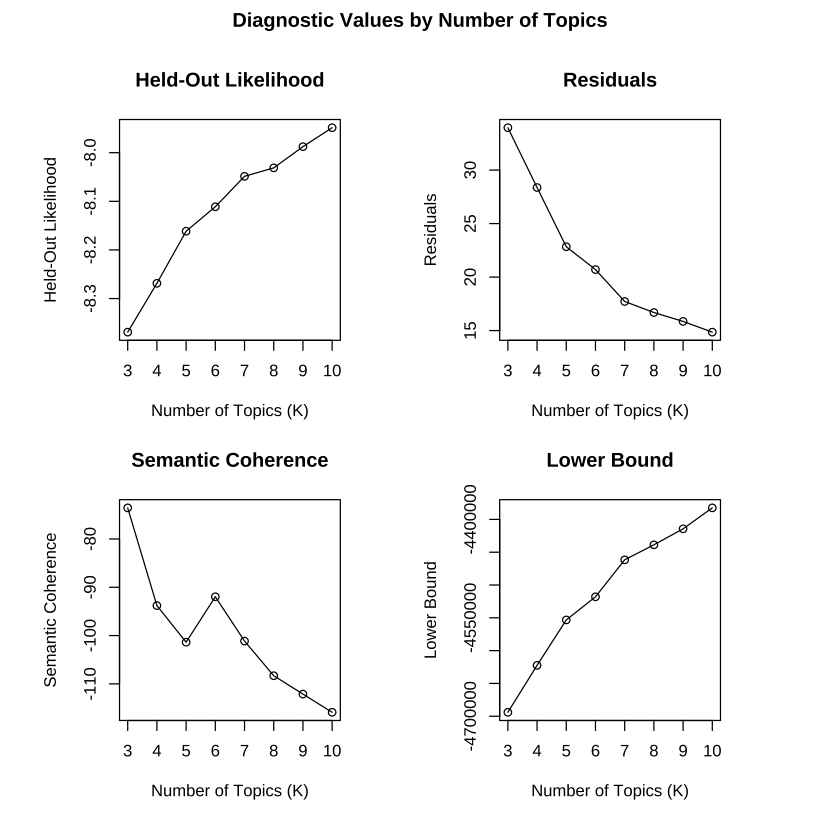

In [4]:
# show result as a plot
# as a result proper K is 6
plot(topicN_storage)

### what does that mean?
- Exclusivity: The degree to which words appearing in a particular subject do not appear in another subject. Corresponding to diffusion validity.

- Semantic coherence: the degree to which words appearing in a particular subject with high probability appear simultaneously. Corresponding to convergent validity.

- Holdout likelihood: The extent to which model predictions persist when some of the data does not exist.

- Residual: An error that cannot explain the model with the input data.

**The higher the exclusivity, semantic coherence, and holdout likelihood, and the smaller the residual, the greater the appropriateness of the model.**

In [5]:
# define & train the model
stm_model <- stm(documents = out$documents, 
                 vocab = out$vocab, 
                 K = 6, 
                 prevalence = ~ Press + Date, 
                 data = out$meta, 
                 max.em.its = 200, 
                 init.type = "Spectral")

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Using only 10000 most frequent terms during initialization...
	 Finding anchor words...
 	......
	 Recovering initialization...
 	....................................................................................................
Initialization complete.
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -9.548) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -8.621, relative change = 9.706e-02) 
....................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -8.375, relative change = 2

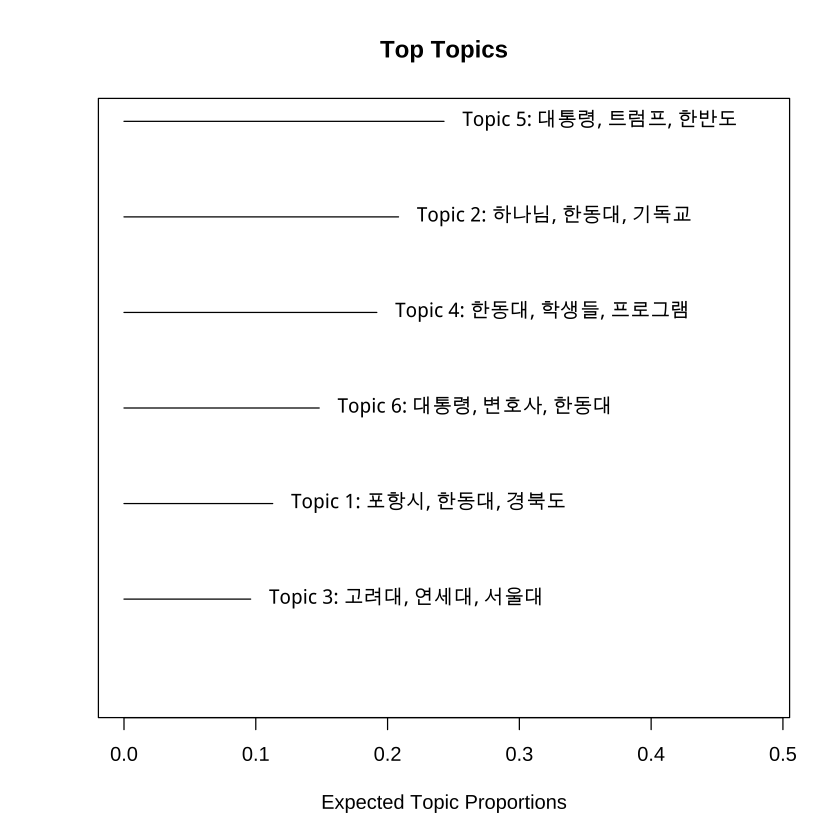

In [6]:
# show result as a plot
plot(stm_model, type = "summary")

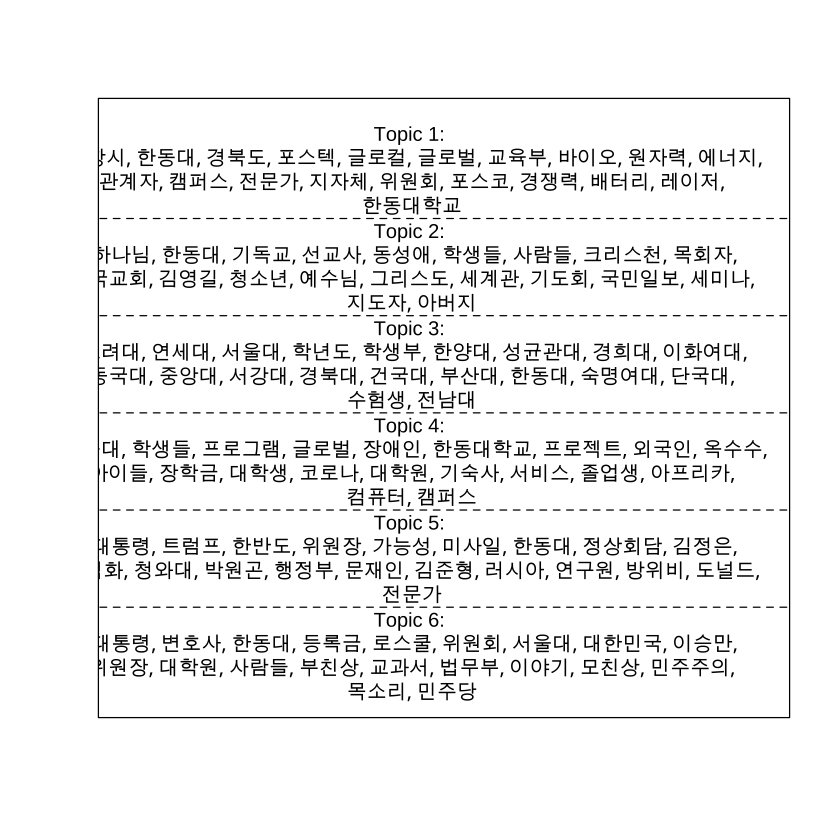

In [7]:
# show topic's label
plot(stm_model, type = "labels")

In [9]:
# words per Topics
labelTopics(stm_model)

Topic 1 Top Words:
 	 Highest Prob: 포항시, 한동대, 경북도, 포스텍, 글로컬, 글로벌, 교육부 
 	 FREX: 배터리, 레이저, 글로컬대학, 백사장, 가속기, 클러스터, 경북도립대 
 	 Lift: ㈜미드바르, 가스전, 간접피해, 감포읍, 강문성, 강선영, 강성묵 
 	 Score: 포항시, 경북도, 글로컬, 포스텍, 레이저, 글로컬대학, 배터리 
Topic 2 Top Words:
 	 Highest Prob: 하나님, 한동대, 기독교, 선교사, 동성애, 학생들, 사람들 
 	 FREX: 하나님, 선교사, 크리스천, 한국교회, 예수님, 기도회, 수련회 
 	 Lift: 가나안, 가수들, 가스펠계, 가이슬러, 가이아, 가정교회, 가정문화원 
 	 Score: 하나님, 기독교, 동성애, 선교사, 한국교회, 크리스천, 예수님 
Topic 3 Top Words:
 	 Highest Prob: 고려대, 연세대, 서울대, 학년도, 학생부, 한양대, 성균관대 
 	 FREX: 학생부, 원광대, 건양대, 선문대, 동덕여대, 우수자, 신라대 
 	 Lift: 가천의과학대, 가천의대, 각종대회수상자, 간호학부, 강상현, 강재원, 강철웅 
 	 Score: 학생부, 학년도, 경동대, 대불대, 선문대, 극동대, 서남대 
Topic 4 Top Words:
 	 Highest Prob: 한동대, 학생들, 프로그램, 글로벌, 장애인, 한동대학교, 프로젝트 
 	 FREX: 유네스코, 개도국, 유산균, 유니트윈, 교육기부, 원어민, 프로바이오틱스 
 	 Lift: 가장들, 가톨릭관동대학교, 간디학교, 강남성혼, 강남세브란스병원, 강병중, 강석윤 
 	 Score: 학생들, 옥수수, 유산균, unai, 장애인, 유니트윈, 대학생 
Topic 5 Top Words:
 	 Highest Prob: 대통령, 트럼프, 한반도, 위원장, 가능성, 미사일, 한동대 
 	 FREX: 트럼프, 미사일, 정상회담, 김정은, 비핵화, 방위비, 도널드 
 	 Lift: 각료회의

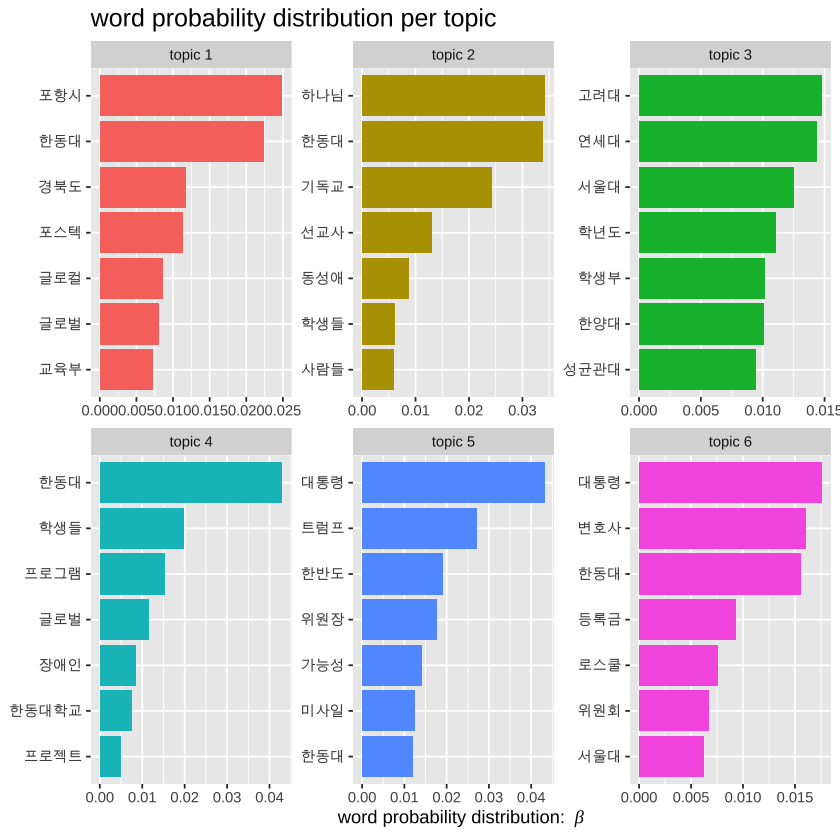

In [10]:
# Tidy the result into a summary data.frame
# Extract the beta value of the topic's probability distribution
td_beta <- stm_model |> tidy(matrix = 'beta') 

# visualization of topic's value
td_beta |>
  group_by(topic) |>
  slice_max(beta, n = 7) |>
  ungroup() |>
  mutate(topic = str_c("topic ", topic)) |>
  ggplot(aes(x = beta, 
             y = reorder_within(term, beta, topic),
             fill = topic)) +
  geom_col(show.legend = F) +
  scale_y_reordered() +
  facet_wrap(~topic, scales = "free") +
  labs(x = expression("word probability distribution: "~beta), y = NULL,
       title = "word probability distribution per topic") +
  theme(plot.title = element_text(size = 15))

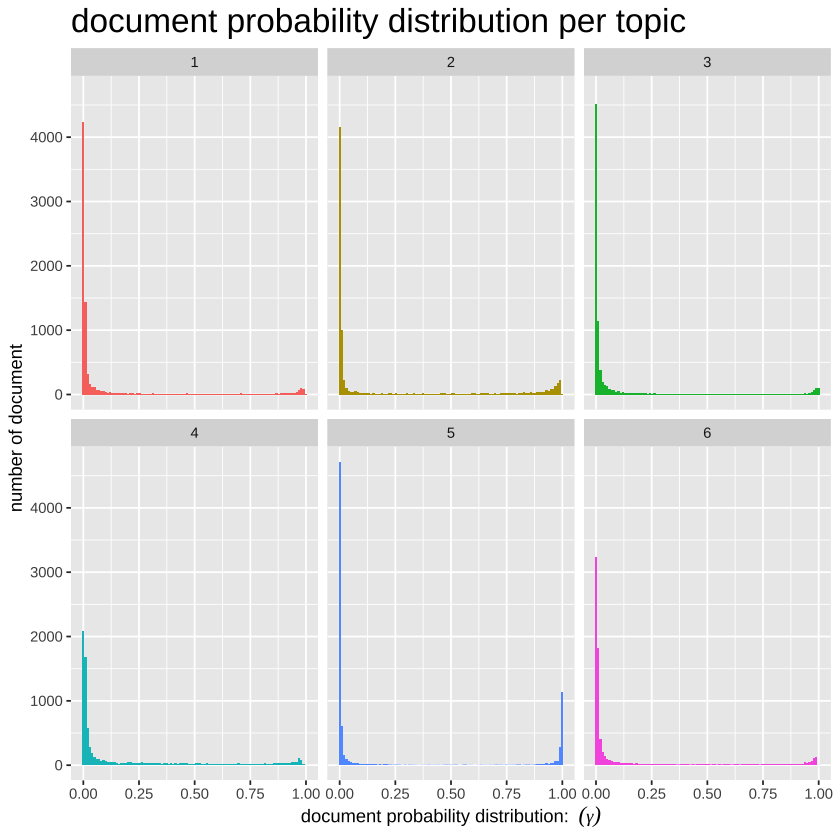

In [12]:
# show topic probability as Gamma distribution
top_terms <- td_beta |>  
  group_by(topic) |> 
  slice_max(beta, n = 8) |> 
  select(topic, term) |> 
  summarise(terms = str_flatten(term, collapse = ", ")) 

td_gamma <- stm_model |> tidy(matrix = 'gamma') 

td_gamma |> 
  ggplot(aes(x = gamma, fill = as.factor(topic))) +
  geom_histogram(bins = 100, show.legend = F) +
  facet_wrap(~topic) + 
  labs(title = "document probability distribution per topic",
       y = "number of document", x = expression("document probability distribution: "~(gamma))) +
  theme(plot.title = element_text(size = 20))

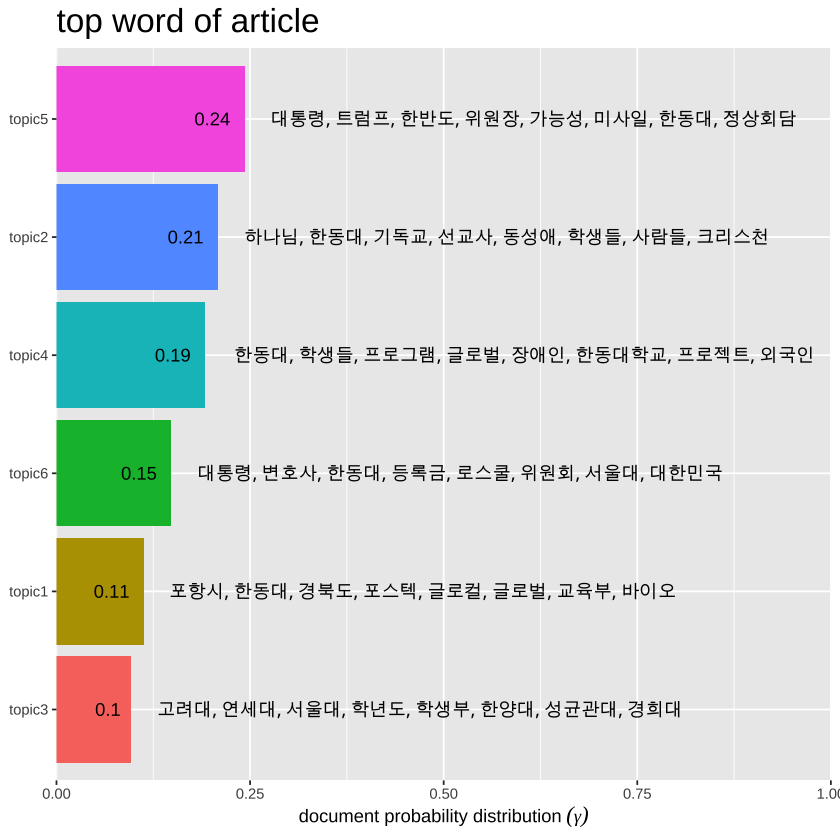

In [13]:
# show tops words per topic
gamma_terms <- td_gamma |> 
  group_by(topic) |> 
  summarise(gamma = mean(gamma)) |> 
  left_join(top_terms, by = 'topic') |> 
  mutate(topic = str_c("topic", topic),
         topic = reorder(topic, gamma))

gamma_terms |> 
  ggplot(aes(x = gamma, y = topic, fill = topic)) +
  geom_col(show.legend = F) +
  geom_text(aes(label = round(gamma, 2)), 
            hjust = 1.4) +                
  geom_text(aes(label = terms), 
            hjust = -0.05) +              
  scale_x_continuous(expand = c(0, 0),    
                     limit = c(0, 1)) +   
  labs(x = expression("document probability distribution"~(gamma)), y = NULL,
       title = "top word of article") +
  theme(plot.title = element_text(size = 20))

### The result of Topic Modeling 

- Topic #1: Topic related to External achievements of Handong University

- Topic #2: Topic related to Christianity at Handong University

- Topic #3: Topic related to college entrance with Handong University

- Topic #4: Topic related to Globalization with Handong University

- Topic #5: Topic related to international politics

- Topic #6: Topic related to Law with Handong University

In [14]:
# show correlation score per topic
cor <- topicCorr(stm_model)

cor$cor

1.00000000,-0.2147779,-0.08513626,-0.09361149,-0.2220701,-0.1582133
-0.21477794,1.0000000,-0.19037963,-0.18382409,-0.3355971,-0.2021173
-0.08513626,-0.1903796,1.00000000,-0.08424909,-0.2250960,-0.1238272
-0.09361149,-0.1838241,-0.08424909,1.00000000,-0.3520138,-0.1554137
-0.22207011,-0.3355971,-0.22509600,-0.35201382,1.0000000,-0.2486044
-0.15821329,-0.2021173,-0.12382721,-0.15541374,-0.2486044,1.0000000


In [15]:
# get result of ANCOVA
stm_effects <- estimateEffect(seq(1,6) ~Press+Date, 
                              stmobj = stm_model,
                              meta = out$meta,
                              uncertainty = "Global")

summary(stm_effects)


Call:
estimateEffect(formula = seq(1, 6) ~ Press + Date, stmobj = stm_model, 
    metadata = out$meta, uncertainty = "Global")


Topic 1:

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2.046e-01  2.096e-02  -9.762  < 2e-16 ***
Press국민일보 -1.256e-02  1.202e-02  -1.046 0.295791    
Press내일신문  3.481e-02  2.096e-02   1.661 0.096773 .  
Press동아일보  5.552e-02  1.565e-02   3.547 0.000392 ***
Press문화일보  5.544e-02  2.073e-02   2.674 0.007517 ** 
Press서울신문  6.574e-02  1.798e-02   3.657 0.000257 ***
Press세계일보  1.072e-01  1.475e-02   7.272 3.86e-13 ***
Press조선일보 -3.306e-02  2.257e-02  -1.465 0.142952    
Press중앙일보  5.506e-02  1.546e-02   3.561 0.000372 ***
Press한겨레   -8.531e-03  1.485e-02  -0.574 0.565784    
Press한국일보  6.032e-02  1.584e-02   3.809 0.000141 ***
Date           1.816e-05  1.165e-06  15.596  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Topic 2:

Coefficients:
                Estimate Std. Error t value Pr(>|t|